# Métodos de Agrupamento

In [147]:
import pandas as pd
import numpy as np
from matplotlib import cm
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn import mixture
# from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

### Simulação e visualização dos dados

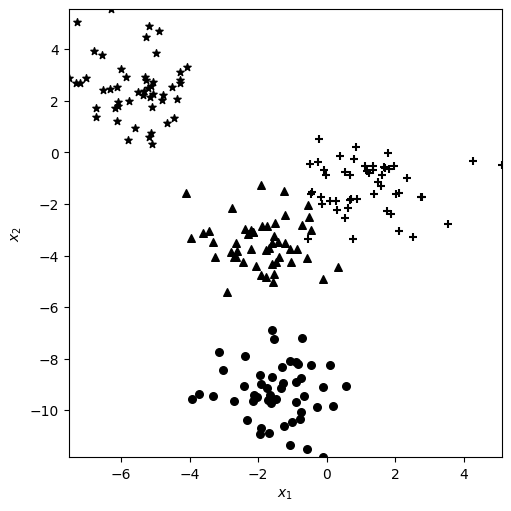

In [148]:
np.random.seed(2)
agrupamentos = 4
x, y = make_blobs(n_features=2, centers=agrupamentos, n_samples=200) # type: ignore

FS = (5,5)
marr = ['o','+','^','*']
fig = plt.figure(constrained_layout=True,figsize=FS)
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)

ax = fig.add_subplot(spec[0, 0])
for i in range(agrupamentos):
    pos =  np.where(y == i)
    ax.scatter(x[pos, 0], x[pos, 1], marker=marr[i], c='k', s=30) # type: ignore

ax.set_xlabel('$x_1$', fontsize=10)
ax.set_ylabel('$x_2$', fontsize=10)
ax.set(xlim=(np.min(x[:,0]), np.max(x[:,0])), ylim=(np.min(x[:,1]), np.max(x[:,1])))
ax = ax

### Agrupamento hierárquico

In [149]:
n_clusters = 4

tipos = ['single','complete','ward','average']
metodo = []

for t in range(4):
    metodo.append(AgglomerativeClustering(n_clusters=n_clusters, linkage=tipos[t], affinity='euclidean')) # type: ignore
    metodo[t].fit(x)

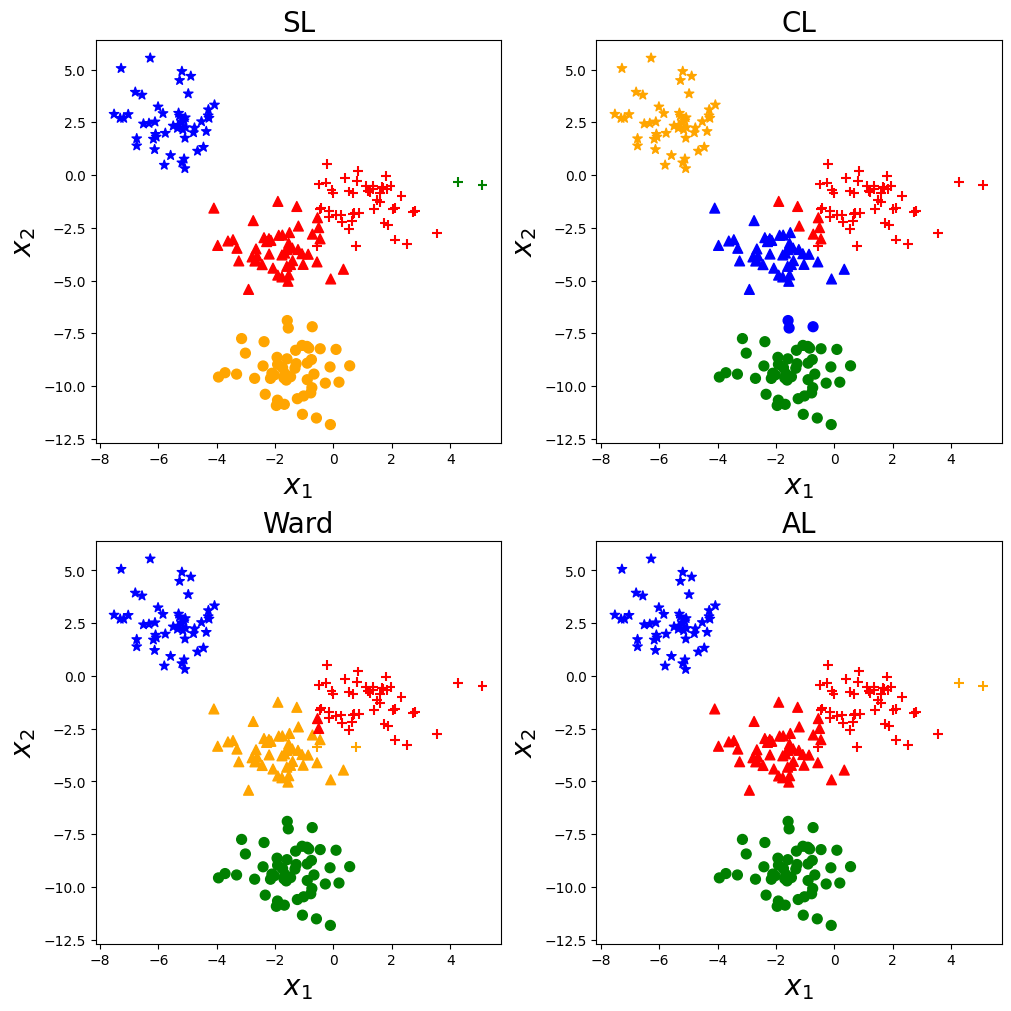

In [150]:
# path_save = 'Data/compAglomeraHierarquicos.png'
FS = (10,10)
posSpec = [[0,0],[0,1],[1,0],[1,1]]
fig = plt.figure(constrained_layout=True,figsize=FS)
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
coll = ['red','blue','green','orange']
nomes = ['SL','CL','Ward','AL']

for t in range(4):
    ax = fig.add_subplot(spec[ posSpec[t][0],posSpec[t][1] ])
    for i in range(n_clusters):
        pos =  np.where(y == i)
        vecCol = []
        for j in metodo[t].labels_[pos]: vecCol.append(coll[j])
        ax.scatter(x[pos, 0], x[pos, 1], marker=marr[i], c=vecCol, s=50) # type: ignore

    ax.set_xlabel('$x_1$', fontsize=20)
    ax.set_ylabel('$x_2$', fontsize=20)
    ax.set_title(nomes[t],fontsize=20)

# plt.savefig(path_save,dpi=300)
plt.show()

### Métodos Sequenciais

#### Menor/maior distância

In [151]:
def find_minmax_tau(x):
    m = x.shape[0]
    minTau, maxTau = np.infty, -1*np.infty
    for i in range(m-1):
        for j in range(i+1,m):
            dist = np.linalg.norm( x[i,:] - x[j,:])
            if dist < minTau: minTau = dist
            if dist > maxTau: maxTau = dist
    return minTau, maxTau

#### Implementação do modelo BSAS

In [152]:
def BSAS(x,tau,maxClusters):
    c = 0
    G = {}
    ind = np.zeros(x.shape[0])
    G[c] = []
    G[c].append( x[0,:])
    vecMu = []
    vecMu.append( x[0,:])
    ind[0] = c

    for i in range(1,x.shape[0]):
        diss = np.zeros(c+1)
        for j in range(c+1):
            diss[j] = np.linalg.norm( x[i,:] - vecMu[j] )
        k = np.argmin(diss)
    
        if (diss[k] > tau) and (c < maxClusters-1):
            c += 1
            G[c] = []; G[c].append( x[i,:] )
            ind[i] = c
            vecMu.append( x[i,:] )
        else:
            G[k].append( x[i,:] )
            ind[i] = k
            vecMu[k] = ((len(G[k]) -1)*vecMu[k] + x[i,:])/len(G[k])
    
    return ind

### Simulação e visualização dos dados

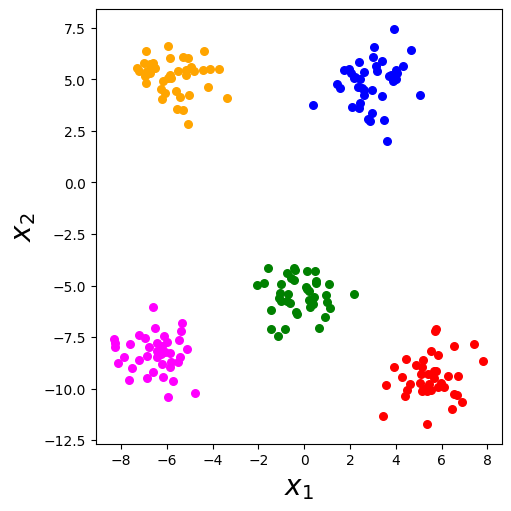

In [153]:
np.random.seed(10)
agrupamentos = 5
x, y = make_blobs(n_features=2, centers=agrupamentos, n_samples=200) # type: ignore
cores = ['red','blue','green','orange','magenta','cyan','grey','darkred','darkblue','darkcyan']
FS = (5,5)
fig = plt.figure(constrained_layout=True,figsize=FS)
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)
ax = fig.add_subplot(spec[0, 0])

for i in range(agrupamentos):
    pos =  np.where(y == i)
    ax.scatter(x[pos, 0], x[pos, 1], marker='o', c=cores[i], s=30) # type: ignore

ax.set_xlabel('$x_1$', fontsize=20)
ax.set_ylabel('$x_2$', fontsize=20)
plt.show()

### Avaliação sobre o número de agrupamentos

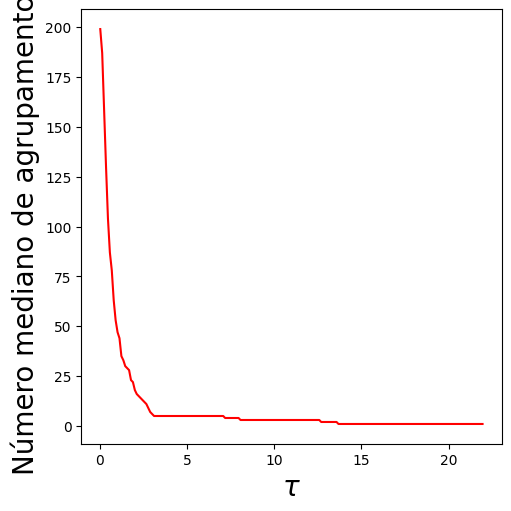

Média:  9.54
Mediana:  3.0


In [154]:
#Busca automatica de agrupamentos
minTau, maxTau = find_minmax_tau(x)
steps = 200 #Número de avaliações no intervalo
repeticoes = 10
vecTau = np.linspace(minTau,maxTau,steps)
vecAgrups = []

for tau in vecTau:
    vec = []
    for _ in range(repeticoes):
        rand = np.argsort(np.random.randint(0,1,x.shape[0]))
        randX = np.copy(x[rand,:])
        res = BSAS(x,tau,randX.shape[0])
        vec.append( np.unique(res).shape[0] )
    vecAgrups.append( np.median(vec) )

FS = (5,5)
fig = plt.figure(constrained_layout=True,figsize=FS)
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)
plt.plot(vecTau,vecAgrups,'r-')
plt.xlabel(r'$\tau$',fontsize=20)
plt.ylabel('Número mediano de agrupamentos',fontsize=20)
plt.show()

print('Média: ', np.mean(vecAgrups))
print('Mediana: ', np.median(vecAgrups))

#### Implementação do método MBSAS

In [155]:
def MBSAS(x,tau,maxClusters):
    c = 0
    G = {}
    ind = np.zeros(x.shape[0])-1
    G[c] = []
    G[c].append( x[0,:])
    vecMu = []
    vecMu.append( x[0,:])
    ind[0] = c

    #Fase de definição dos agrupamentos
    for i in range(1,x.shape[0]):
        diss = np.zeros(c+1)
        for j in range(c+1):
            diss[j] = np.linalg.norm(x[i,:] - vecMu[j])
        k = np.argmin(diss)
    
        if (diss[k] > tau) and (c < maxClusters-1):
            c += 1
            G[c] = []
            G[c].append(x[i,:])
            ind[i] = c
            vecMu.append(x[i,:])
    
    #Fase de associação aos agrupamentos
    diss = np.zeros(c+1)
    for i in range(0,x.shape[0]):
        if ind[i] == -1:
            for j in range(c+1):
                diss[j] = np.linalg.norm(x[i,:] - vecMu[j])
        
            k = np.argmin(diss)
            G[k].append(x[i,:])
            ind[i] = k
            vecMu[k] = ((len(G[k]) -1)*vecMu[k] + x[i,:])/len(G[k])

    return ind

###  Determinação de agrupamentos via BSAS e MBSAS
* Os parâmetros de BSAS/MBSAS são:
    * x: conjunto de dados ($\mathcal{I}$)
    * maxClusters: número máximo de agrupamentos permitidos ($c$)
    * tau: limiar de dissimilaridade ($\tau$)

In [156]:
np.random.seed(2)
agrupamentos = 4
x, y = make_blobs(n_features=2, centers=agrupamentos, n_samples=200) # type: ignore

In [157]:
agrup1 = BSAS(x, 2.0, 4) #(x,tau,maxClusters)
agrup2 = BSAS(x, 3.0, 10)
agrup3 = MBSAS(x, 2.0, 4)
agrup4 = MBSAS(x, 3.0, 10)

### Visualização dos agrupamentos

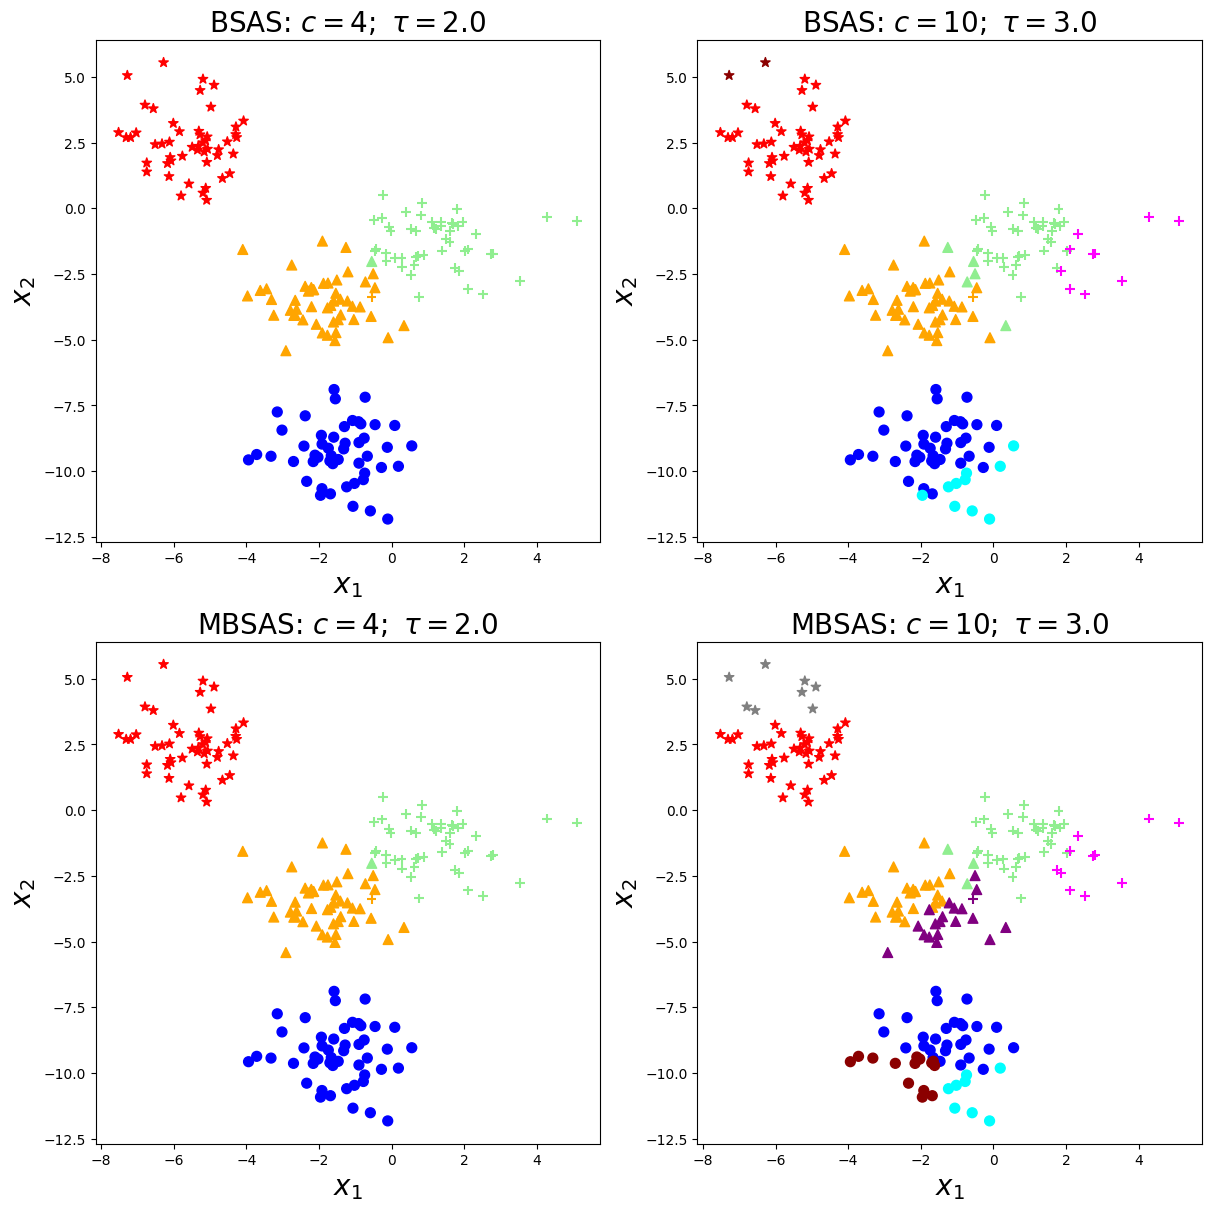

In [158]:
FS = (12,12)
fig = plt.figure(constrained_layout=True, figsize=FS)
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
cores = ['red','blue','lightgreen','orange','magenta','cyan','darkred','grey','purple','darkgreen']
ax = fig.add_subplot(spec[0,0])

for i in range(agrupamentos):
    pos =  np.array(np.where(y == i))[0]
    vecCor = []
    for j in agrup1[pos]: 
        vecCor.append(cores[int(j)])
    ax.scatter(x[pos, 0], x[pos, 1], marker=marr[i], c=vecCor, s=50) # type: ignore

ax.set_xlabel('$x_1$', fontsize=20); ax.set_ylabel('$x_2$', fontsize=20)
ax.set_title(r'BSAS: $c = 4; \ \tau = 2.0$',fontsize=20)
ax = fig.add_subplot(spec[0,1])

for i in range(agrupamentos):
    pos =  np.array(np.where(y == i))[0]
    vecCor = []
    for j in agrup2[pos]: vecCor.append(cores[int(j)])
    ax.scatter(x[pos, 0], x[pos, 1], marker=marr[i], c=vecCor, s=50) # type: ignore

ax.set_xlabel('$x_1$', fontsize=20); ax.set_ylabel('$x_2$', fontsize=20)
ax.set_title(r'BSAS: $c = 10; \ \tau = 3.0$',fontsize=20)
ax = fig.add_subplot(spec[1,0])

for i in range(agrupamentos):
    pos =  np.array(np.where(y == i))[0]
    vecCor = []
    for j in agrup3[pos]: vecCor.append(cores[int(j)])
    ax.scatter(x[pos, 0], x[pos, 1], marker=marr[i], c=vecCor, s=50) # type: ignore
ax.set_xlabel('$x_1$', fontsize=20); ax.set_ylabel('$x_2$', fontsize=20)
ax.set_title(r'MBSAS: $c = 4; \ \tau = 2.0$',fontsize=20)
ax = fig.add_subplot(spec[1,1])

for i in range(agrupamentos):
    pos =  np.array(np.where(y == i))[0]
    vecCor = []
    for j in agrup4[pos]: vecCor.append(cores[int(j)])
    ax.scatter(x[pos, 0], x[pos, 1], marker=marr[i], c=vecCor, s=50) # type: ignore
ax.set_xlabel('$x_1$', fontsize=20); ax.set_ylabel('$x_2$', fontsize=20)
ax.set_title(r'MBSAS: $c = 10; \ \tau = 3.0$',fontsize=20)

plt.show()

### Construção do modelo de mistura de gaussianas

In [159]:
np.random.seed(2)
agrupamentos = 4
x, y = make_blobs(n_features=2, centers=agrupamentos, n_samples=200) # type: ignore

In [160]:
n_clusters = 4
gmm = mixture.GaussianMixture(n_components=n_clusters)
gmm.fit(x)

GaussianMixture(n_components=4)

### Reinterpretação do modelo de mistura na forma de agrupamentos

In [161]:
yEst = []
for i in range(x.shape[0]):
    yEst.append(np.argmax(gmm.predict_proba([x[i,:]])))
    
yEst = np.array(yEst)

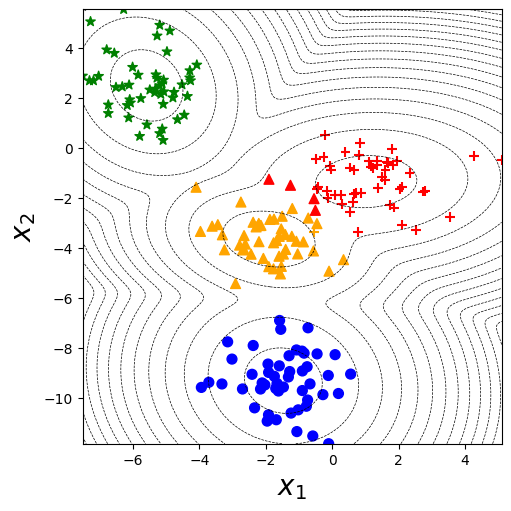

In [162]:
FS = (5,5)
fig = plt.figure(constrained_layout=True,figsize=FS)
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)
coll = ['red','blue','green','orange']
ax = fig.add_subplot(spec[0,0])

for i in range(n_clusters):
    pos = np.where( y == i )
    vecCol = [];
    for j in pos[0]: vecCol.append(coll[ yEst[j] ])
    ax.scatter(x[pos, 0], x[pos, 1], marker=marr[i], c=vecCol, s=50) # type: ignore
    
ax.set_xlabel('$x_1$', fontsize=20)
ax.set_ylabel('$x_2$', fontsize=20)
ax.set(xlim=(np.min(x[:,0]), np.max(x[:,0])), ylim=(np.min(x[:,1]), np.max(x[:,1])))

N = 200
X,Y = np.meshgrid( np.linspace(np.min(x[:,0]), np.max(x[:,0]), N) , np.linspace(np.min(x[:,1]), np.max(x[:,1]),N) )
Z = gmm.score_samples( np.array([X.ravel(), Y.ravel()]).T )
CS = plt.contour(X, Y,  Z.reshape(X.shape), levels=20, linewidths=0.5, colors='k')
plt.show()

## K-Means e Fuzzy K-Means

### critério inicialização dos lambdas

In [163]:
def compute_lambdas(data,mu,beta):
    expo = 2.0/(beta-1.0)
    m,_ = data.shape
    k,_ = mu.shape
    lamb = np.zeros((m,k))
    diss = np.zeros((k))
    for i in range(0,m):
        for j in range(0,k):
            diss[j] = np.linalg.norm( data[i,:] - mu[j,:] )+0.0001
        
        for j in range(0,k):
            s = 0
            for ell in range(0,k):
                s += ( diss[j] / diss[ell] )**expo
            lamb[i,j] = 1/s
    return lamb

### Atualização dos centroides

In [164]:
def compute_mu(data,lamb,beta):
    m,dim = data.shape
    _,k = lamb.shape
    mu = np.zeros((k,dim))
    for j in range(0,k):
        num = np.zeros((dim))
        den = 0
        for i in range(0,m):
            num[:] += (lamb[i,j]**beta) * data[i,:]
            den += (lamb[i,j]**beta)
        mu[j,:] = num[:]/den
    return mu

### critério inicialização

In [165]:
def intra_cluster_var(data,mu):
    m,_ = data.shape
    k,_ = mu.shape
    totalCost = np.zeros((k))
    countClus = np.zeros((k))
    for i in range(0,m):
        diss = np.zeros((k))
        for j in range(0,k):
            diss[j] = np.linalg.norm( data[i,:] - mu[j,:] )**2
        pos = np.argmin(diss)
        totalCost[pos] += diss[pos]
        countClus[pos] += 1
    clusterVar = (1/m) * np.sum(totalCost)

    return clusterVar

In [166]:
def init_centroids(data,k):
    m,dim = data.shape
    bestCost = 10**10
    mu = np.zeros((k,dim))
    bestMu = np.zeros((k,dim))
    for _ in range(0, int(np.ceil(0.1*m)) ):
        randPos = np.random.randint(0,m,k)
        mu = data[randPos,:]
        cost = intra_cluster_var(data,mu)
        if cost < bestCost:
            bestCost = cost
            bestMu = np.copy(mu)
    return bestMu

### Função para definir o agrupamento segundo o lambda

In [167]:
def assign_label(lamb):
    m,_ = lamb.shape
    lab = np.zeros((m))
    for i in range(0,m): lab[i] = np.argmax(lamb[i,:])
    return lab

### Método Fuzzy K-Means

In [168]:
def fuzzy_kmeans(data,k,beta,epsilon):
    mu = init_centroids(data,k)
    lamb = compute_lambdas(data,mu,beta)

    while True:
        mu_old = np.copy(mu)
        mu = compute_mu(data, lamb, beta) #Cálculo dos centroides
        lamb = compute_lambdas(data, mu, beta) #Atualização dos lambdas
        
        if np.linalg.norm(mu - mu_old) < epsilon: break
        
    lab = assign_label(lamb)
    return lab

### Simulação e visualização dos dados

In [169]:
np.random.seed(2)
agrupamentos = 4
x, y = make_blobs(n_features=2, centers=agrupamentos, n_samples=200) # type: ignore

### Parametrização

In [170]:
path_out = 'KM-FKM_clus4.png'
n_clusters = 5
epsilon = 0.0001
beta = 5.0

clusFKM = fuzzy_kmeans(x,n_clusters,beta,epsilon)
km = KMeans(n_clusters=n_clusters, max_iter=1000, tol=epsilon)
clusKM = km.fit_predict(x)

### Visualização do resultado de agrupamento

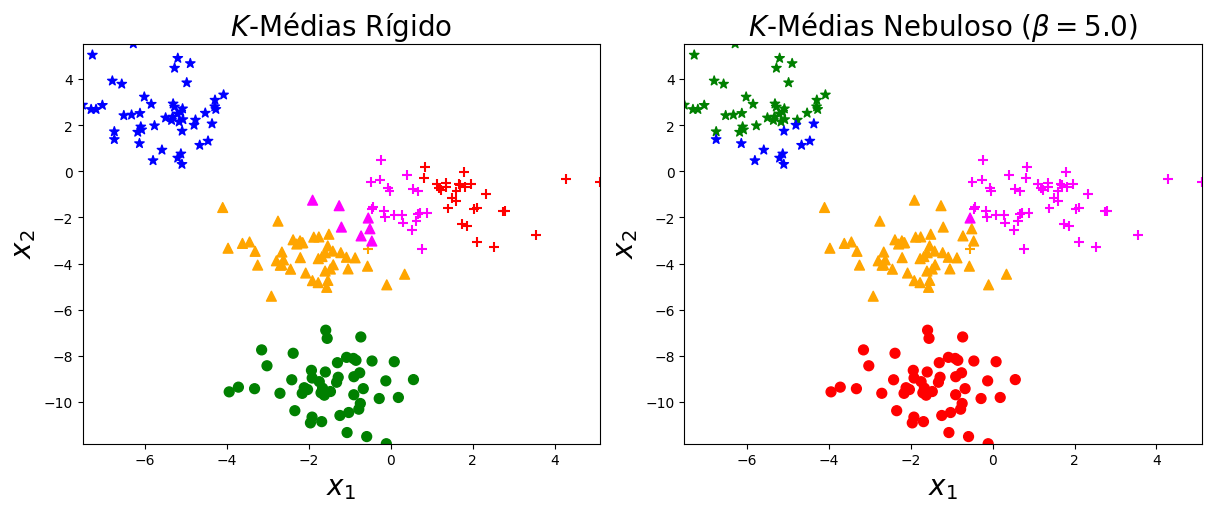

In [171]:
FS = (12,5)
fig = plt.figure(constrained_layout=True,figsize=FS)
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
coll = ['red','blue','green','orange','magenta','cyan','darkred','grey']
marr = ['o','+','^','*','D','x','p','h']

#(K-Médias)
ax = fig.add_subplot(spec[0,0])
for i in range(n_clusters):
    pos = np.where( y == i )
    vecCol = []
    for j in pos[0]: vecCol.append(coll[ int(clusKM[j]) ])
    ax.scatter(x[pos, 0], x[pos, 1], marker=marr[i], c=vecCol, s=50) # type: ignore
ax.set_xlabel('$x_1$', fontsize=20)
ax.set_ylabel('$x_2$', fontsize=20)
ax.set_title('$K$-Médias Rígido', fontsize=20)
ax.set(xlim=(np.min(x[:,0]), np.max(x[:,0])), ylim=(np.min(x[:,1]), np.max(x[:,1])))
   
#(FKM)
ax = fig.add_subplot(spec[0,1])
for i in range(n_clusters):
    pos = np.where( y == i )
    vecCol = []
    for j in pos[0]: vecCol.append(coll[ int(clusFKM[j]) ])
    ax.scatter(x[pos, 0], x[pos, 1], marker=marr[i], c=vecCol, s=50) # type: ignore
ax.set_xlabel('$x_1$', fontsize=20)
ax.set_ylabel('$x_2$', fontsize=20)
ax.set_title('$K$-Médias Nebuloso ('+r'$\beta = $' + str(beta)+')', fontsize=20)
ax.set(xlim=(np.min(x[:,0]), np.max(x[:,0])), ylim=(np.min(x[:,1]), np.max(x[:,1])))
plt.show()

## Mapas auto-organizáveis (SOM)

### Normaliza dados

In [172]:
def norm_data(data):
    val = []
    for i in range(data.shape[0]):
        val.append( np.linalg.norm( data[i,:] ) )

    fator = val[ np.argmax(val) ]
    data /= fator
    return data

### Normaliza pesos/mapa

In [173]:
def norm_map(Map):
    val = []
    for i in range(Map.shape[1]):
        for j in range(Map.shape[2]):
            val.append( np.linalg.norm( Map[:,i,j] ) )

    fator = val[ np.argmax(val) ]
    Map /= fator
    return Map

### Verifica o neurônio mais próximo/similar

In [174]:
def neuro_win(x,Map,L):
    cost = np.infty
    wx,wy = 0,0
    for i in range(L):
        for j in range(L):
            dif = np.linalg.norm( x - Map[:,i,j] )
            if dif < cost:
                cost = dif
                wx,wy = i,j
    return wx,wy

### Atualização dos pesos do mapa de neurônios

In [175]:
def update_map(pos,L,x,Map,eta,sig):
    upMap = np.copy(Map)
    for i in range(L):
        for j in range(L):
            alpha = neigh_rate(pos,[i,j],sig) # type: ignore
            upMap[:,i,j] = Map[:,i,j] + eta*alpha*(x - Map[:,i,j])
    upMap = norm_map(upMap)
    return upMap

### Função para ponderação do ajuste na vizinhança

In [176]:
def neigh_rate(pos1,pos2,sig):
    return np.exp(-(np.linalg.norm(np.array((pos1))-np.array((pos2)))**2)/(2*(sig**2)))

### Função para associação padrão-agrupamento

In [177]:
def map_decision(x,Map,clusterMap,L):
    ind = []
    for k in range(x.shape[0]):
        i,j = neuro_win(x[k,:],Map,L)
        ind.append( clusterMap[i,j] )
    return ind

### Simulação dos dados (o mesmo de exemplos anteriores)

In [178]:
np.random.seed(2)
agrupamentos = 4
x, y = make_blobs(n_features=2, centers=agrupamentos, n_samples=200)

### Ajuste do SOM

In [179]:
L = 10          #Largura do mapa de neurônios
sig = 1.0       #Parâmetros sigma usado na fun. viz. topológica
eta = 1.0       #Taxa de aprendizado
epsilon = 0.001 #Tolerância para detecção de convergência
m,n  = x.shape #Número de observações/dimensões
x = norm_data(x) #Normalização dos dados
Map = np.zeros((x.shape[1],L,L)) #Gera mapa de neurônios (n x L x L)
#Inicialização aleatória dos neurônios
pos = np.argsort(np.random.randint(0,1,m)); k = 0

for i in range(L):
    for j in range(L):
        Map[:,i,j] = x[pos[k],:]
        k += 1

epoca = 0

while True:
    oldMap = np.copy(Map)
    #Define uma ortem aletória a cada iteração
    pos = np.argsort(np.random.randint(0,1,m))
    xs = np.copy(x[pos,:]) #Cópia 'desordenada' do conjunto de dados

    for i in range(m):
        pi,pj = neuro_win(xs[i,:],Map,L)
        Map = update_map([pi,pj],L,xs[i,:],Map,eta,sig)

    if np.max(np.linalg.norm(Map - oldMap)) < epsilon: break
    print(np.max( np.linalg.norm(Map - oldMap)))

    epoca += 1
    eta = 1.0/epoca

5.617660023676371
2.0277342909446405
0.7505528907043947
0.42706376323353
0.23409401334973873
0.11710420654324312
0.09037984632984361
0.05171495289298153
0.035216763151412984
0.025291372016544838
0.022429290218555754
0.016999598659171843
0.019348500454586685
0.013093526229572954
0.009911409567398114
0.00795353637835352
0.01240940120519279
0.011676836085301357
0.007878255398068341
0.005845075688174045
0.009214069225001488
0.0063108007526364715
0.008642782575535595
0.006576333361858783
0.009407534558870128
0.006174024748857485
0.007767763056647128
0.005310619613790681
0.0048797969571459515
0.00367964517071705
0.002925481101042913
0.00242682732534184
0.006105013836395754
0.005021021022120309
0.006031035047832711
0.009993977461401042
0.00714444111737438
0.005268772737116064
0.003992092799041059
0.003098509227068175
0.0024587423561414834
0.0019922597937124917
0.0016469773671650748
0.0013880552007041053
0.0011915134927486225
0.0010404714778399014


### Determinação dos agrupamentos e visualização do mapa

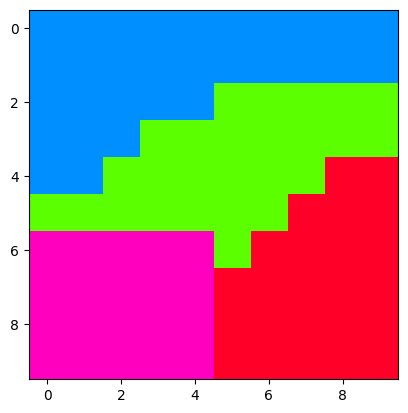

In [180]:
agrupamentos = 4
coll = ['red','blue','green','magenta','orange','cyan','darkred','grey']
g = AgglomerativeClustering(n_clusters=agrupamentos, linkage='complete', affinity='euclidean')
agrup = g.fit( Map.reshape((n,L*L), order='C').T)
clusterMap = np.reshape(agrup.labels_ , (L,L))
plt.imshow(clusterMap, cmap=cm.gist_rainbow) # type: ignore
plt.show()

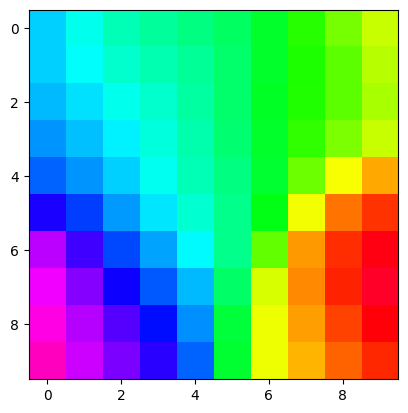

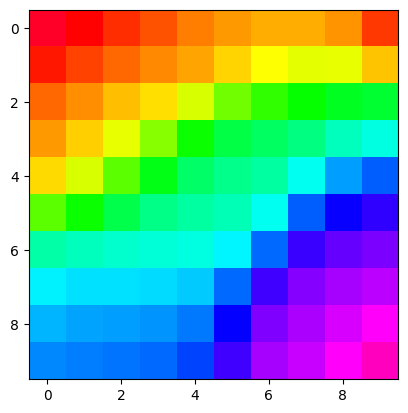

In [181]:
plt.imshow(Map[0,:,:], cmap=cm.gist_rainbow) # type: ignore
plt.show()

plt.imshow(Map[1,:,:], cmap=cm.gist_rainbow) # type: ignore
plt.show()

### Agrupamento dos dados (segundo interpretação do mapa de neurônios)

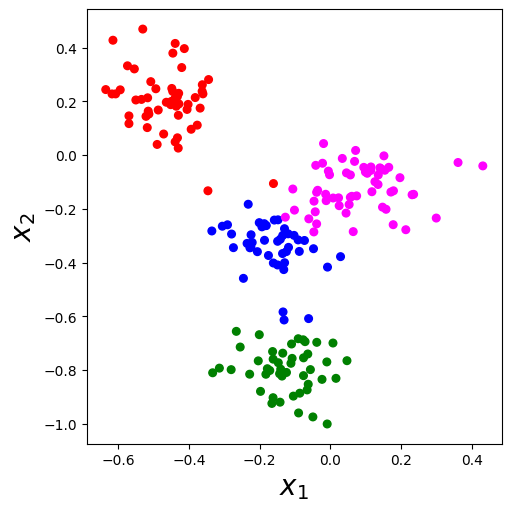

In [182]:
res = map_decision(x,Map,clusterMap,L)
FS = (5,5)
fig = plt.figure(constrained_layout=True,figsize=FS)
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)
coll = ['red','blue','green','magenta','orange','cyan','darkred','grey']
marr = ['o','+','^','*','D','x','p','h']
vecCol = []
for c in res: vecCol.append( coll[c] )

#(K-Médias)
ax = fig.add_subplot(spec[0,0])
ax.scatter(x[:, 0], x[:, 1], marker='o', c=vecCol, s=30) # type: ignore
ax.set_xlabel('$x_1$', fontsize=20)
ax.set_ylabel('$x_2$', fontsize=20)
plt.show()